## CAPSTONE PROJECT - CLASSIFICATION

#### IMPORT PACKAGES

In [97]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [98]:
# Import Package
import os
import pandas as pd
import numpy as np

# Package untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Package untuk oversampling dengan SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE

# Package untuk cleaning, modelling, dan evaluation model
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [99]:
# Membuat path untuk mengidentifikasi letak directory
# Catatan : pastikan path yang anda masukkan sesuai dengan directory data anda. Kemungkinan besar path di contoh ini berbeda dengan penyimpanan data anda
path = '/content/drive/MyDrive/Narasio Data/Junior Data Scientist/Meet 5/3. Classification - NPL Credit Scoring/'

In [100]:
# Melihat isi dari folder path
os.listdir(path)

['.ipynb_checkpoints',
 'npl_credit_scoring_test.csv',
 'npl_credit_scoring_train.csv']

#### READ DATASET

In [101]:
# Load data
df = pd.read_csv(os.path.join(path, "npl_credit_scoring_train.csv"), encoding='utf-8')
df.head()

,X,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,kode_cabang,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,rasio_pembayaran_6bulan,skor_delikuensi,flag_kredit_macet,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan
0,92,5,5972272,6000000.0,5068230.0,0.0,0.0,5206434.0,NaN,12.19,0.00,7.84,43.92,0,0,9.916667,0.0,1041286.8,0.867739,0.000000,0.059401,0.041536,0.919164,0.919635
1,316,2,136453,65000000.0,128750.0,0.0,0.0,0.0,NaN,100.00,0.00,74.92,100.36,0,0,3.500000,0.0,0.0,0.000000,0.000000,0.023722,0.013271,0.022847,0.007724
2,624,1,1354080,3000000.0,1369203.0,0.0,15000.0,0.0,NaN,100.00,0.00,82.01,0.00,3,0,8.500000,15000.0,0.0,0.000000,0.005000,0.145833,0.000000,0.627426,0.899309
3,628,2,1076660,49000000.0,752108.0,0.0,775440.0,0.0,NaN,99.07,0.00,29.72,57.32,0,0,4.333333,775440.0,0.0,0.000000,0.015825,0.017617,0.177094,0.013699,0.255363
4,947,3,42281368,34000000.0,43130581.0,0.0,0.0,41144841.0,NaN,0.00,22.63,37.49,43.58,0,1,7.000000,0.0,13714947.0,1.210142,0.000000,0.412361,0.014556,1.205087,1.116092


In [102]:
# Cek ukuran dataframe df
df.shape

(15343, 24)

#### PROBLEM STATEMENT

### Permasalahan

> Analisa kredit adalah penilaian kelayakan terhadap pengaju kredit. Fungsi analisa kredit di antaranya sebagai dasar bagi bank dalam menentukan diterimanya pengajuan kredit, menentukan tingkat suku bunga kredit serta jaminan yang disyaratkan untuk dipenuhi nasabah, dan evaluasi. Banyak faktor yang dipertimbangkan analis kredit sebelum memberikan rekomendasi menerima atau menolak sebuah pengajuan kredit. **Bank A ingin membuat sistem penilaian kelayakan kredit secara otomatis** berdasarkan data yang mereka miliki. Lakukan analisis dan **prediksikan flag_kredit_macet** berdasarkan variabel yang ada.

### Deskripsi Data

1. X: Nomor
2. jumlah_kartu: Jumlah kartu aktif yang dimiliki pelanggan
3. outstanding: Total saldo pemakaian kartu kredit
4. limit_kredit: Jumlah maksimum limit kredit yang dapat digunakan
5. tagihan: Jumlah tagihan pada bulan terakhir
6. total_pemakaian_tunai: Total pemakaian transaksi tunai pada bulan terakhir (cash advance)
7. total_pemakaian_retail: Total pemakaian transaksi retail pada bulan terakhir
8. sisa_tagihan_tidak_terbayar: Jumlah tagihan tidak terbayar pada bulan terakhir
9. rasio_pembayaran: Rasio perbandingan jumlah yang dibayar dengan tagihan pada bulan terakhir
10. persentasi_overlimit: Presentasi overlimit
11. rasio_pembayaran_3bulan: Rata-rata rasio pembayaran 3 bulan terakhir
12. rasio_pembayaran_6bulan: Rata-rata rasio pembayaran 3 bulan sebelum 3 bulan terakhir
13. skor_delikuensi: Kecenderungan pembayaran menunggak selama 12 bulan ke depan (skor rendah berarti buruk)
14. flag_kredit_macet: Flag yang menandakan apakah kartu kredit macet atau tidak
15. jumlah_tahun_sejak_pembukaan_kredit: Jumlah tahun sejak pembuatan kartu kredit pertama kali
16. total_pemakaian: Total pemakaian kartu kredit (tunai dan retail) pada bulan terakhir
17. sisa_tagihan_per_jumlah_kartu: Jumlah tagihan yang tidak terbayar pada bulan terakhir dibagi jumlah kartu aktif
18. sisa_tagihan_per_limit: Jumlah tagihan yang tidak terbayar pada bulan terakhir dibagi total limit
19. total_pemakaian_per_limit: Total pemakaian kartu kredit (tunai dan retail) pada bulan terakhir dibagi total limit
20. pemakaian_3bln_per_limit: Rata-rata pemakaian selama 3 bulan terakhir dibagi total limit
21. pemakaian_6bln_per_limit: Rata-rata pemakaian selama 3 bulan sebelum 3 bulan terakhir dibagi total limit
22. utilisasi_3bulan: Utilisasi kartu kredit selama 3 bulan terakhir
23. utilisasi_6bulan: Utilisasi kartu kredit selama 3 bulan sebelum 3 bulan terakhir

> Dalam kasus ini, akan melakukan prediksi flag_kredit_macet sebagai variabel respon.

#### EDA

In [103]:
# Cek informasi yang terdapat di data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15343 entries, 0 to 15342
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   X                                    15343 non-null  int64  
 1   jumlah_kartu                         15343 non-null  int64  
 2   outstanding                          15343 non-null  int64  
 3   limit_kredit                         15343 non-null  float64
 4   tagihan                              15343 non-null  float64
 5   total_pemakaian_tunai                15343 non-null  float64
 6   total_pemakaian_retail               15343 non-null  float64
 7   sisa_tagihan_tidak_terbayar          15343 non-null  float64
 8   kode_cabang                          15243 non-null  object 
 9   rasio_pembayaran                     15343 non-null  float64
 10  persentasi_overlimit                 15343 non-null  float64
 11  rasio_pembayaran_3bulan     

Dari info tersebut tidak terdapat missing value. Selanjutnya akan dicari tahu, apakah kartu kredit macet lebih banyak dibandingkan yang tidak atau sebaliknya?

In [104]:
# Cek jumlah flag kredit macet 0 dan 1
df['flag_kredit_macet'].value_counts()

0    13999
1     1344
Name: flag_kredit_macet, dtype: int64

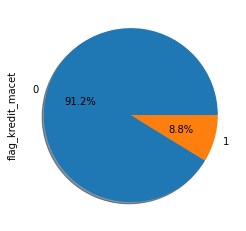

In [105]:
# Mencari perbandingan label/class
df['flag_kredit_macet'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True)
plt.show()

Dari pie-chart tersebut, dapat dikatakan bahwa kredit yang tidak macet lebih banyak, data ini tidak seimbang (imbalanced data). Untuk mengatasi itu, akan dilakukan oversampling dengan SMOTE.

In [106]:
# Analisa deskriptif
df.describe()

,X,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,rasio_pembayaran_6bulan,skor_delikuensi,flag_kredit_macet,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan
count,15343.000000,15343.000000,1.534300e+04,1.534300e+04,1.534300e+04,1.534300e+04,1.534300e+04,1.534300e+04,15343.000000,15343.000000,15343.000000,15343.000000,15343.000000,15343.000000,15343.000000,1.534300e+04,1.534300e+04,15343.000000,15343.000000,15343.000000,15343.000000,15343.000000,15343.000000
mean,7750.138956,2.507332,1.160634e+07,2.081037e+07,8.087595e+06,7.468477e+04,2.032315e+06,8.138304e+06,64.482234,3.347169,50.539467,81.291786,0.004758,0.087597,6.636067,2.107030e+06,2.964641e+06,0.468332,0.109579,0.167506,0.202896,0.571362,0.534084
std,4472.966163,1.014525,2.415412e+07,2.960443e+07,1.766835e+07,6.205923e+05,7.959575e+06,1.925786e+07,797.324307,9.257389,1333.723881,1472.735798,0.114362,0.282717,4.682317,8.125462e+06,6.262742e+06,0.473221,0.200651,0.192300,0.275018,0.412303,0.432826
min,1.000000,1.000000,0.000000e+00,3.000000e+06,2.004300e+04,0.000000e+00,-1.566720e+07,0.000000e+00,-18138.000000,0.000000,-57792.340000,-77056.000000,0.000000,0.000000,0.750000,-1.566720e+07,0.000000e+00,0.000000,-0.632000,-0.126000,-0.569000,0.000288,0.000000
25%,3875.500000,2.000000,1.997592e+06,5.000000e+06,8.150830e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,20.200000,21.600000,0.000000,0.000000,2.920000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.035000,0.032900,0.189000,0.155000
50%,7752.000000,2.000000,4.724856e+06,9.000000e+06,3.141692e+06,0.000000e+00,2.010420e+05,2.750772e+06,26.900000,0.000000,50.000000,65.600000,0.000000,0.000000,5.666667,2.480000e+05,1.209318e+06,0.335929,0.022100,0.108000,0.117000,0.576000,0.496000
75%,11624.500000,3.000000,1.061836e+07,2.200000e+07,7.420343e+06,0.000000e+00,1.403758e+06,7.139904e+06,100.000000,1.070000,91.335000,100.000000,0.000000,0.000000,9.330000,1.513168e+06,3.083416e+06,0.930000,0.128000,0.239424,0.285000,0.917000,0.864000
max,15493.000000,16.000000,7.980586e+08,1.000000e+09,6.280000e+08,2.884057e+07,2.850000e+08,4.440000e+08,68983.000000,190.000000,75575.000000,54899.000000,5.000000,1.000000,34.416667,3.140000e+08,1.480000e+08,7.240000,4.600000,3.490000,8.110000,8.125671,9.730000


Jumlah kartu terbanyak adalah 16 kartu. Dari beberapa kolom seperti total_pemakaian, rasio_pembayaran, dan total_pemakaian_per_limit, nilai minimum bernilai negatif.

Selain itu, terdapat perbedaan yang signifikan antara mean dan median dari kolom outstanding, limit_kredit, dan total_pemakaian yang mengindikasikan outlier atau skewed distribution.

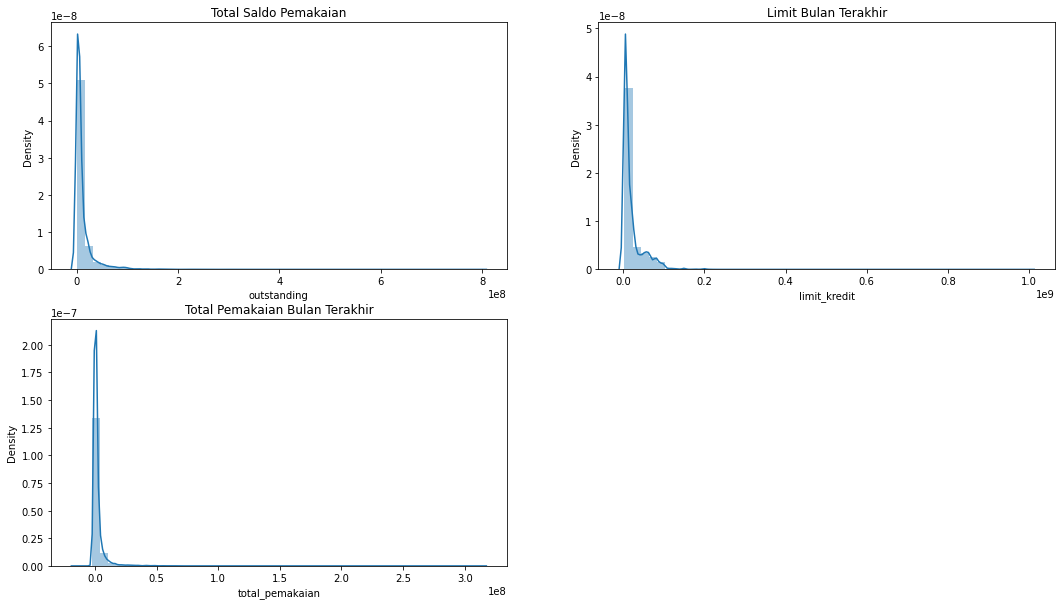

In [107]:
# Cek distribusi kolom outstanding, limit_kredit, dan total_pemakaian
plt.figure(figsize=(18,10))
plt.subplot(221)
sns.distplot(df['outstanding'])
plt.title("Total Saldo Pemakaian")
plt.subplot(222)
sns.distplot(df['limit_kredit'])
plt.title("Limit Bulan Terakhir")
plt.subplot(223)
sns.distplot(df['total_pemakaian'])
plt.title("Total Pemakaian Bulan Terakhir")
plt.show()

Berdasarkan distribusinya, ketiga kolom memiliki bentuk positively skewed distribution

Apakah semakin banyak jumlah kartu semakin besar total saldo yang dipakai?

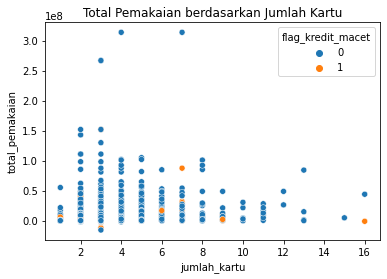

In [108]:
sns.scatterplot(data=df, x="jumlah_kartu", y="total_pemakaian", hue="flag_kredit_macet")
plt.title("Total Pemakaian berdasarkan Jumlah Kartu")
plt.show()

Jumlah kartu tidak membuat nasabah memakai saldo kredit yang banyak, namun total pemakaian yang besar ada pada mereka yang punya sekitar 2-3 kartu kredit.

Apakah sisa tagihan tidak terbayar yang tinggi mengindikasikan kredit macet?

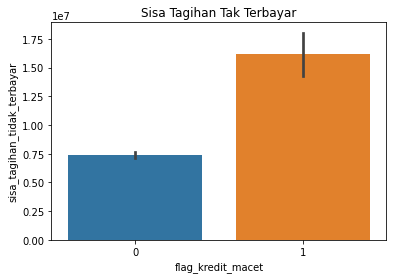

In [109]:
# Boxplot Sisa Tagihan dengan Kredit Macet
sns.barplot(x="flag_kredit_macet", y="sisa_tagihan_tidak_terbayar", data=df)
plt.title("Sisa Tagihan Tak Terbayar")
plt.show()

Nasabah dengan sisa tagihan yang besar cenderung menunjukkan indikasi kredit macet.

Bagaimana jika persentasi overlimit yang besar terhadap flag kredit macet?

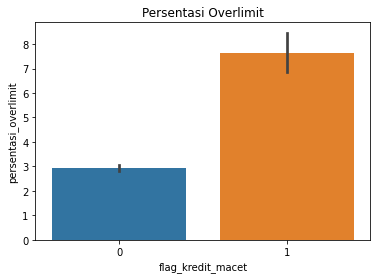

In [110]:
# Boxplot Sisa Tagihan dengan Kredit Macet
sns.barplot(x="flag_kredit_macet", y="persentasi_overlimit", data=df)
plt.title("Persentasi Overlimit")
plt.show()

Nasabah yang terindikasi kredit macet cenderung memiliki persentasi overlimit yang tinggi dibanding yang tidak.

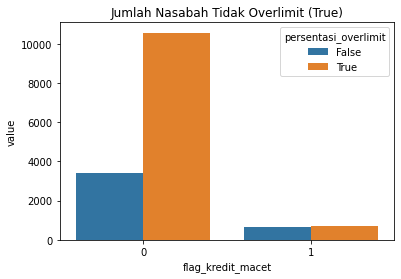

In [111]:
# Cek kredit macet dengan persentasi overlimit
flag_overlimit = pd.crosstab(df['flag_kredit_macet'], (df['persentasi_overlimit']==0))

# Buat hasil crosstab menjadi dataframe
flag_overlimit_stacked = flag_overlimit.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=flag_overlimit_stacked.flag_kredit_macet, y=flag_overlimit_stacked.value, hue=flag_overlimit_stacked.persentasi_overlimit)
plt.title("Jumlah Nasabah Tidak Overlimit (True)")
plt.show()

Ternyata nasabah yang tagihannya tidak overlimit (True, overlimit = 0) banyak dimiliki oleh mereka yang kreditnya tidak macet.

Apakah nasabah yang menggunakan saldo kreditnya di atas 30% (utilitas kredit > 30%) cenderung terindikasi kredit macet?

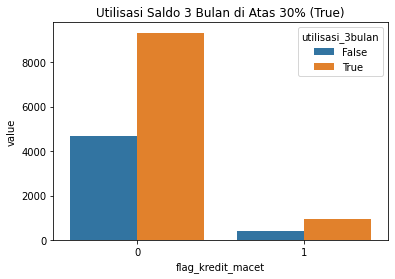

In [112]:
# Cek kredit macet dengan persentasi overlimit
flag_utilisasi = pd.crosstab(df['flag_kredit_macet'], (df['utilisasi_3bulan']>0.3))

# Buat hasil crosstab menjadi dataframe
flag_utilisasi_stacked = flag_utilisasi.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=flag_utilisasi_stacked.flag_kredit_macet, y=flag_utilisasi_stacked.value, hue=flag_utilisasi_stacked.utilisasi_3bulan)
plt.title("Utilisasi Saldo 3 Bulan di Atas 30% (True)")
plt.show()

Nasabah dengan utilisasi kredit > 30% selama 3 bulan cenderung terindikasi tidak macet. Begitu pula bagi nasabah yang cenderung terindikasi kredit macet adalah mereka yang memiliki utilisasi > 30% sehingga tidak ada pengaruh.

#### DATA PRE-PROCESSING

##### Missing Value

In [113]:
# cek missing value
df.isnull().sum()

X                                        0
jumlah_kartu                             0
outstanding                              0
limit_kredit                             0
tagihan                                  0
total_pemakaian_tunai                    0
total_pemakaian_retail                   0
sisa_tagihan_tidak_terbayar              0
kode_cabang                            100
rasio_pembayaran                         0
persentasi_overlimit                     0
rasio_pembayaran_3bulan                  0
rasio_pembayaran_6bulan                  0
skor_delikuensi                          0
flag_kredit_macet                        0
jumlah_tahun_sejak_pembukaan_kredit      0
total_pemakaian                          0
sisa_tagihan_per_jumlah_kartu            0
sisa_tagihan_per_limit                   0
total_pemakaian_per_limit                0
pemakaian_3bln_per_limit                 0
pemakaian_6bln_per_limit                 0
utilisasi_3bulan                         0
utilisasi_6

Nilai yang missing hanya ada pada kolom kode_cabang. Kolom ini tidak begitu dibutuhkan untuk dilakukan analisis, begitu juga kolom X. Sehingga, kedua kolom tersebut dapat dibuang.

In [114]:
# Drop kolom X dan kode_cabang
df2 = df.drop(['X','kode_cabang'], axis=1)

In [115]:
# cek kembali missing value
df2.isnull().sum()

jumlah_kartu                           0
outstanding                            0
limit_kredit                           0
tagihan                                0
total_pemakaian_tunai                  0
total_pemakaian_retail                 0
sisa_tagihan_tidak_terbayar            0
rasio_pembayaran                       0
persentasi_overlimit                   0
rasio_pembayaran_3bulan                0
rasio_pembayaran_6bulan                0
skor_delikuensi                        0
flag_kredit_macet                      0
jumlah_tahun_sejak_pembukaan_kredit    0
total_pemakaian                        0
sisa_tagihan_per_jumlah_kartu          0
sisa_tagihan_per_limit                 0
total_pemakaian_per_limit              0
pemakaian_3bln_per_limit               0
pemakaian_6bln_per_limit               0
utilisasi_3bulan                       0
utilisasi_6bulan                       0
dtype: int64

Semua kolom merupakan kolom numerik sehingga tidak diperlukan encoding.

##### Cek Korelasi

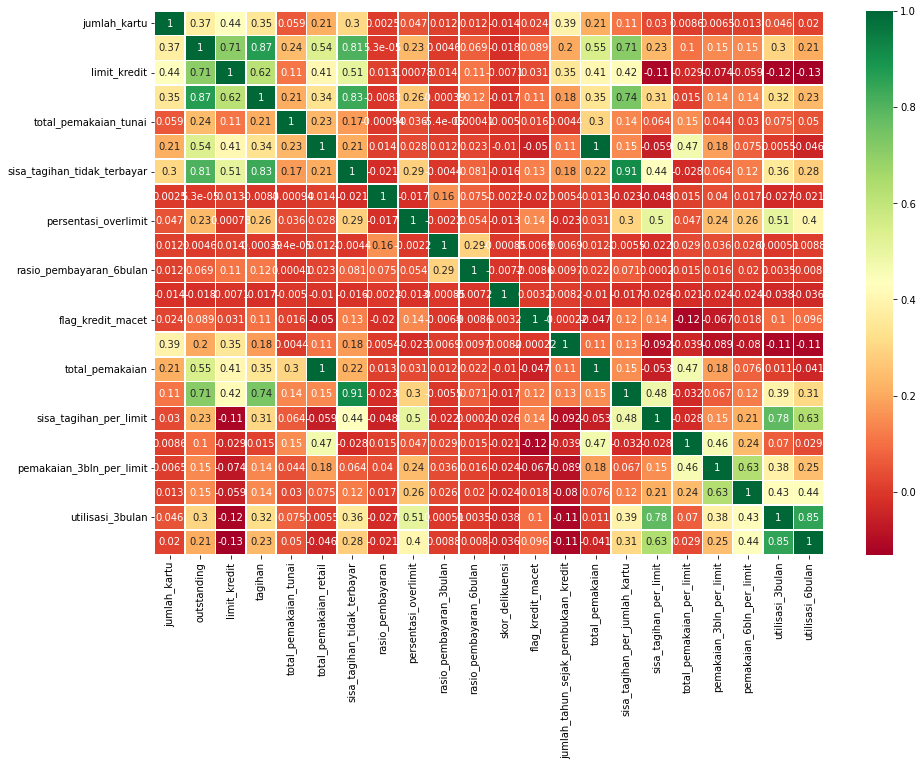

In [116]:
# Melakukan perhitungan nilai korelasi dengan mengasumsikan data adalah data interval.
sns.heatmap(df2.corr(),linewidths=.5,annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

In [117]:
# Cek Urutan korelasi terendah ke tertinggi
korelasi = df2.corr()["flag_kredit_macet"].sort_values()
korelasi

total_pemakaian_per_limit             -0.116207
pemakaian_3bln_per_limit              -0.067138
total_pemakaian_retail                -0.049683
total_pemakaian                       -0.047419
rasio_pembayaran                      -0.020056
rasio_pembayaran_6bulan               -0.008569
rasio_pembayaran_3bulan               -0.006857
jumlah_tahun_sejak_pembukaan_kredit   -0.000222
skor_delikuensi                        0.003236
total_pemakaian_tunai                  0.016374
pemakaian_6bln_per_limit               0.018036
jumlah_kartu                           0.023667
limit_kredit                           0.030994
outstanding                            0.089344
utilisasi_6bulan                       0.096429
utilisasi_3bulan                       0.103251
tagihan                                0.107561
sisa_tagihan_per_jumlah_kartu          0.122347
sisa_tagihan_tidak_terbayar            0.129020
sisa_tagihan_per_limit                 0.138163
persentasi_overlimit                   0

#### FEATURE ENGINEERING

##### Feature Selection

Beberapa variabel memiliki korelasi yang kuat satu sama lain (>0.7) sehingga dapat dihilangkan dan memilih beberapa variabel saja untuk dilakukan modeling.

In [118]:
drop = ['outstanding', 'limit_kredit', 'tagihan', 'total_pemakaian_retail', 'sisa_tagihan_per_jumlah_kartu', 'sisa_tagihan_per_limit', 'utilisasi_6bulan', 'rasio_pembayaran_6bulan', 'pemakaian_6bln_per_limit']
df2 = df2.drop(drop, axis=1)
df2.head()

,jumlah_kartu,total_pemakaian_tunai,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,skor_delikuensi,flag_kredit_macet,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,total_pemakaian_per_limit,pemakaian_3bln_per_limit,utilisasi_3bulan
0,5,0.0,5206434.0,12.19,0.00,7.84,0,0,9.916667,0.0,0.000000,0.059401,0.919164
1,2,0.0,0.0,100.00,0.00,74.92,0,0,3.500000,0.0,0.000000,0.023722,0.022847
2,1,0.0,0.0,100.00,0.00,82.01,3,0,8.500000,15000.0,0.005000,0.145833,0.627426
3,2,0.0,0.0,99.07,0.00,29.72,0,0,4.333333,775440.0,0.015825,0.017617,0.013699
4,3,0.0,41144841.0,0.00,22.63,37.49,0,1,7.000000,0.0,0.000000,0.412361,1.205087


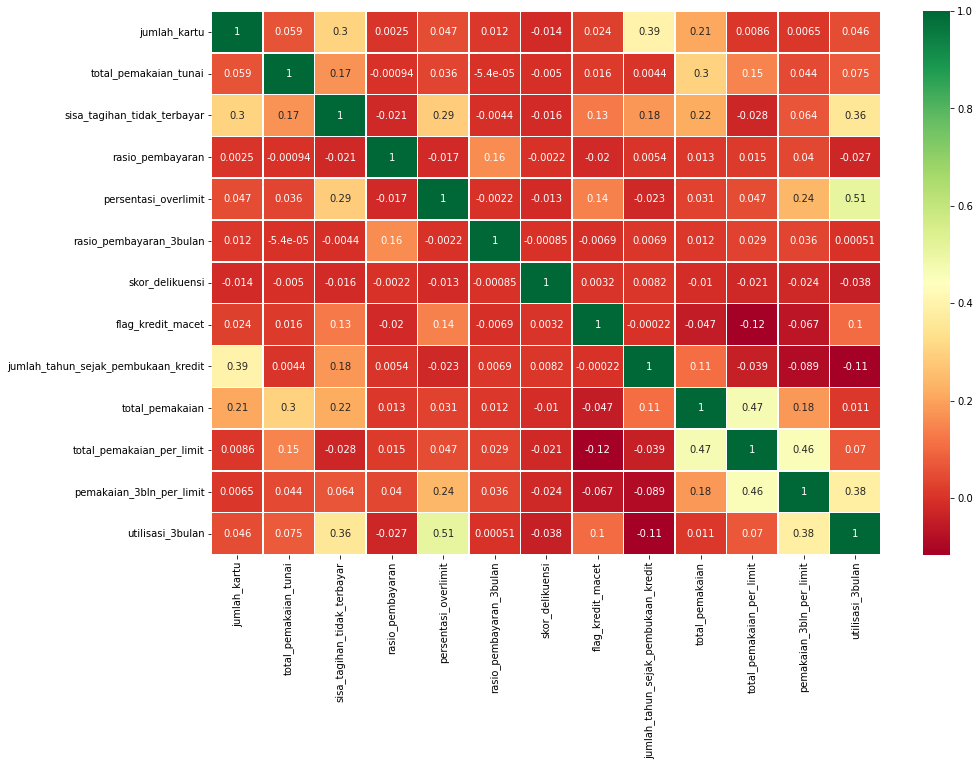

In [119]:
# Melakukan perhitungan nilai korelasi dengan mengasumsikan data adalah data interval.
sns.heatmap(df2.corr(),linewidths=.5,annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.show()

Sekarang variabel yang sudah diseleksi tidak saling memiliki korelasi yang kuat sehingga akan digunakan untuk modeling.

##### Scaling

Scaling digunakan untuk merubah skala pada data. Penggunaan scaling dapat membantu mengurangi gap antar kolom dalam data, proses ini tidak merubah distribusi dalam data, hanya melakukan pengubahan skala data.

In [120]:
# Scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df2)
scaled_df

array([[ 2.45705985, -0.12034826, -0.15224772, ..., -0.54613382,
        -0.56218756,  0.84358671],
       [-0.50008508, -0.12034826, -0.42261025, ..., -0.54613382,
        -0.74772845, -1.33041141],
       [-1.48580006, -0.12034826, -0.42261025, ..., -0.52121408,
        -0.11270459,  0.13598207],
       ...,
       [-0.50008508, -0.12034826, -0.18649132, ..., -0.3472743 ,
        -0.6349969 ,  0.36779586],
       [-0.50008508, -0.12034826, -0.29290038, ..., -0.54613382,
        -0.7627531 ,  0.81975627],
       [ 1.47134487, -0.12034826,  0.67305543, ...,  0.10676335,
         1.64589329,  0.78012737]])

In [122]:
# Membuat dataframe dari hasil scalling
scaled_df = pd.DataFrame(scaled_df, columns=df2.columns)
scaled_df

,jumlah_kartu,total_pemakaian_tunai,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,skor_delikuensi,flag_kredit_macet,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,total_pemakaian_per_limit,pemakaian_3bln_per_limit,utilisasi_3bulan
0,2.457060,-0.120348,-0.152248,-0.065587,-0.361579,-0.032016,-0.041605,-0.309850,0.700659,-0.259321,-0.546134,-0.562188,0.843587
1,-0.500085,-0.120348,-0.422610,0.044548,-0.361579,0.018281,-0.041605,-0.309850,-0.669790,-0.259321,-0.546134,-0.747728,-1.330411
2,-1.485800,-0.120348,-0.422610,0.044548,-0.361579,0.023597,26.191755,-0.309850,0.398092,-0.257474,-0.521214,-0.112705,0.135982
3,-0.500085,-0.120348,-0.422610,0.043381,-0.361579,-0.015611,-0.041605,-0.309850,-0.491810,-0.163884,-0.467261,-0.779479,-1.352599
4,0.485630,-0.120348,1.713981,-0.080876,2.083034,-0.009785,-0.041605,3.227371,0.077728,-0.259321,-0.546134,1.273342,1.537089
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15338,-0.500085,-0.120348,-0.213002,0.025107,-0.361579,0.023064,-0.041605,-0.309850,-0.278945,0.810969,2.344556,0.637018,-0.570865
15339,0.485630,-0.120348,0.214357,-0.080876,1.593680,-0.021474,-0.041605,-0.309850,0.434400,-0.258151,-0.541828,-0.137840,1.233692
15340,-0.500085,-0.120348,-0.186491,-0.070842,-0.361579,-0.030727,-0.041605,-0.309850,0.558275,-0.224922,-0.347274,-0.634997,0.367796
15341,-0.500085,-0.120348,-0.292900,-0.051978,-0.361579,-0.032196,-0.041605,-0.309850,-1.061347,-0.259321,-0.546134,-0.762753,0.819756


#### MODELING & EVALUATION

##### Oversampling with SMOTE

In [123]:
# Membagi train test data
X = df2.drop('flag_kredit_macet', axis=1)
y = df2['flag_kredit_macet']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X Train : ", len(X_train))
print("y Train : ", len(y_train))
print("X Test : ", len(X_test))
print("y Test : ", len(y_test))

X Train :  10740
y Train :  10740
X Test :  4603
y Test :  4603


In [124]:
# Ringkasan class distribution
print("Before oversampling: ", Counter(y_train))

Before oversampling:  Counter({0: 9821, 1: 919})


In [125]:
# fit and apply the transform
SMOTE = SMOTE()
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

In [126]:
# Ringkasan class distribution setelah oversampling
print("After oversampling: ", Counter(y_train_SMOTE))

After oversampling:  Counter({0: 9821, 1: 9821})


##### Logistic Regression (Stats Model)

Train Model

In [129]:
Input = sm.add_constant(X_train_SMOTE)

In [130]:
model = sm.Logit(y_train_SMOTE, X_train_SMOTE)
result = model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.590386
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.148     
Dependent Variable: y                AIC:              23216.7389
Date:               2021-11-02 07:25 BIC:              23311.3640
No. Observations:   19642            Log-Likelihood:   -11596.   
Df Model:           11               LL-Null:          -13615.   
Df Residuals:       19630            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0948     0.0151     6.2904   0.0000    0.0653    0.1244
x2        0.0000     0.0000     7.8220   0.0000    0.0000 

In [134]:
scaled_df.columns

Index(['jumlah_kartu', 'total_pemakaian_tunai', 'sisa_tagihan_tidak_terbayar',
       'rasio_pembayaran', 'persentasi_overlimit', 'rasio_pembayaran_3bulan',
       'skor_delikuensi', 'flag_kredit_macet',
       'jumlah_tahun_sejak_pembukaan_kredit', 'total_pemakaian',
       'total_pemakaian_per_limit', 'pemakaian_3bln_per_limit',
       'utilisasi_3bulan'],
      dtype='object')

In [133]:
# odds ratio
list(np.exp(result.params))

[1.0994853089682406,
 1.000000262271559,
 1.0000000056982739,
 0.991912304087718,
 1.0655264079384426,
 1.0000113777491,
 1.293542295697664,
 0.9946603714817482,
 0.9999999773976699,
 0.03801228972202915,
 0.1930475045846814,
 1.1960591972625296]

Nilai odds ratio digunakan untuk mengetahui besarnya hubungan. Meningkatnya jumlah kartu meningkatkan kecenderungan untuk kredit macet sebesar 1.09 kali lipat. Selain itu, meningkatnya skor delinkuensi meningkatkan kecenderungan 1.29 kali lipat untuk kredit macet. Begitu juga dengan meningkatnya utilisasi 3 bulan sebesar 1.19 akan meningkatkan kecenderungan nasabah untuk terindikasi kredit macet.

Prediksi Model

In [135]:
prediction = result.predict(X_test)

In [136]:
pred_results = pd.DataFrame(prediction, columns = ["logreg_pred"])
pred_results["prediksi"] = pred_results['logreg_pred'].apply(lambda x: 1 if x > 0.5 else 0)
pred_results['actual'] = y_test
pred_results.head()

,logreg_pred,prediksi,actual
10432,0.032339,0,0
5046,0.565220,1,1
7042,0.607410,1,1
1962,0.479158,0,0
6245,0.555660,1,0


Train Model

In [168]:
LR = LogisticRegression()
LR.fit(X_train_SMOTE, y_train_SMOTE)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predict Model

In [169]:
y_pred = LR.predict(X_test)
logreg_test = pd.merge(X_test, y_test, left_index=True, right_index=True, how='outer')
logreg_test['prediction'] = y_pred
logreg_test.head()

,jumlah_kartu,total_pemakaian_tunai,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,skor_delikuensi,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,total_pemakaian_per_limit,pemakaian_3bln_per_limit,utilisasi_3bulan,flag_kredit_macet,prediction
10432,2,0.0,0.0,100.0,0.0,101.00,0,10.200,31214548.0,0.35100,0.6030,0.6830,0,0
5046,2,0.0,4202429.0,0.0,0.0,5.00,0,7.500,20000.0,0.00286,0.0000,0.5510,1,1
7042,2,0.0,19507458.0,0.0,0.0,5.38,0,2.830,0.0,0.00000,0.0205,1.0300,1,1
1962,2,0.0,784723.0,41.8,0.0,0.00,0,0.917,0.0,0.00000,0.0000,0.3730,0,1
6245,3,0.0,0.0,0.0,0.0,25.00,0,11.800,0.0,0.00000,0.0000,0.0108,0,0


In [170]:
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train_SMOTE, LR.predict(X_train_SMOTE)))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.69      0.55      0.61      9821
           1       0.63      0.76      0.69      9821

    accuracy                           0.65     19642
   macro avg       0.66      0.65      0.65     19642
weighted avg       0.66      0.65      0.65     19642



In [171]:
print('Classification Report Testing Model (Logistic Regression) :')
print(classification_report(y_test, y_pred))

Classification Report Testing Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.96      0.54      0.69      4178
           1       0.15      0.76      0.24       425

    accuracy                           0.56      4603
   macro avg       0.55      0.65      0.47      4603
weighted avg       0.88      0.56      0.65      4603



##### Logistic Regression (SKLearn)

In [157]:
log_model = LogisticRegression().fit(X_train_SMOTE, y_train_SMOTE)
print('Model Logistic Regression yang terbentuk adalah: \n', log_model)

Model Logistic Regression yang terbentuk adalah: 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Performansi Model Training - Menampilkan Metrics

In [158]:
# Predict
y_train_pred = log_model.predict(X_train_SMOTE)
# Print classification report 
print('Classification Report Training Model (Logistic Regression) :')
print(classification_report(y_train_SMOTE, y_train_pred))

Classification Report Training Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.69      0.55      0.61      9821
           1       0.63      0.76      0.69      9821

    accuracy                           0.65     19642
   macro avg       0.66      0.65      0.65     19642
weighted avg       0.66      0.65      0.65     19642



Performansi Model Training - Menampilkan Plots

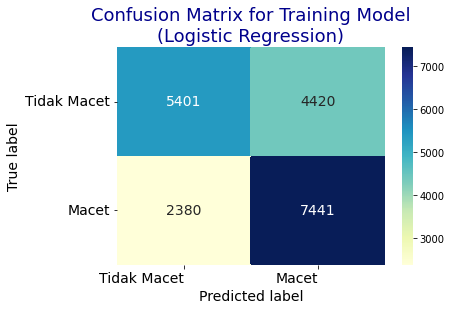

In [160]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train_SMOTE, y_train_pred)), ('Tidak Macet', 'Macet'), ('Tidak Macet', 'Macet'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

Performansi Data Testing - Menampilkan Metrics

In [161]:
# Predict
y_test_pred = log_model.predict(X_test)
# Print classification report 
print('Classification Report Testing Model (Logistic Regression) :')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Logistic Regression) :
              precision    recall  f1-score   support

           0       0.96      0.54      0.69      4178
           1       0.15      0.76      0.24       425

    accuracy                           0.56      4603
   macro avg       0.55      0.65      0.47      4603
weighted avg       0.88      0.56      0.65      4603



Performansi Data Testing - Menampilkan Plots

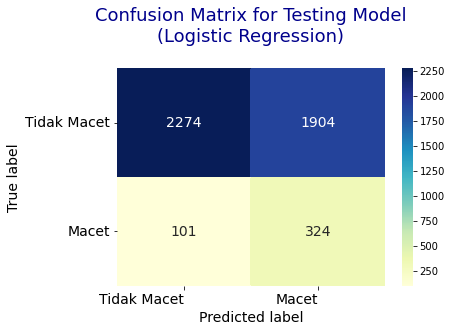

In [162]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('Tidak Macet', 'Macet'), ('Tidak Macet', 'Macet'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

Dari hasil dan analisa di atas, maka:

*   Dari data training terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebear 65% dan recall sebesar 76%, dengan detil tebakan macet yang sebenarnya benar macet adalah 7441, tebakan tidak macet yang sebenarnya tidak macet adalah 5401, tebakan tidak macet yang sebenarnya benar macet adalah 2380 dan tebakan macet yang sebenernya tidak macet adalah 4420.
*   Dari data testing terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 56% dan recall sebesar 76%, dengan detil tebakan macet yang sebenarnya benar macet adalah 324, tebakan tidak macet yang sebenarnya tidak macet adalah 2274, tebakan tidak macet yang sebenarnya benar macet adalah 101 dan tebakan macet yang sebenernya tidak macet adalah 1904.

##### Evaluation Model

In [163]:
# Memilih k-fold (dipilih k = 5)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [164]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
scores = cross_val_score(logreg, X_train_SMOTE, y_train_SMOTE, cv=kfold)
print("Cross-validation scores: {:.3f}".format(scores.mean()))

Cross-validation scores: 0.653


In [165]:
param_grid_lr = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'class_weight':['balanced', None]}

grid_search_lr = GridSearchCV(logreg, param_grid_lr, cv=kfold)
grid_search_lr.fit(X_train_SMOTE, y_train_SMOTE)
print("Best parameters: {}".format(grid_search_lr.best_params_))
print("Best cross-validation score: {:.3}".format(grid_search_lr.best_score_))

Best parameters: {'C': 0.001, 'class_weight': 'balanced'}
Best cross-validation score: 0.653


Ternyata tidak terjadi peningkatan model score ketika dilakukan tuning parameter.

##### Random Forest Classifier

In [147]:
# Train the model
rdf_model = RandomForestClassifier().fit(X_train_SMOTE, y_train_SMOTE)
print(rdf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Performansi Data Training - Menampilkan Metrics

In [148]:
# Performansi data training - menampilkan metrics
y_train_pred = rdf_model.predict(X_train_SMOTE)
print('Classification Report Training Model (Random Forest) :')
print(classification_report(y_train_SMOTE, y_train_pred))

Classification Report Training Model (Random Forest) :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9821
           1       1.00      1.00      1.00      9821

    accuracy                           1.00     19642
   macro avg       1.00      1.00      1.00     19642
weighted avg       1.00      1.00      1.00     19642



Performansi Data Training - Menampilkan Plots

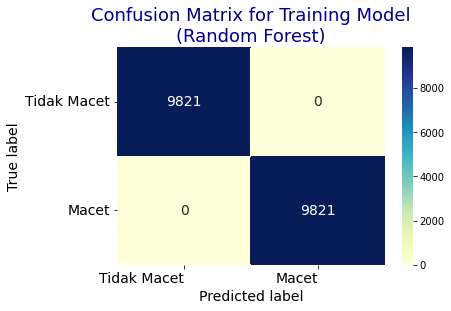

In [149]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train_SMOTE, y_train_pred)), ('Tidak Macet', 'Macet'), ('Tidak Macet', 'Macet'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

Performansi Data Testing - Menampilkan Metrics

In [150]:
# Predict
y_test_pred = rdf_model.predict(X_test)
# Print classification report 
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4178
           1       0.34      0.41      0.38       425

    accuracy                           0.87      4603
   macro avg       0.64      0.67      0.65      4603
weighted avg       0.88      0.87      0.88      4603



Performansi Data Testing - Menampilkan Plots

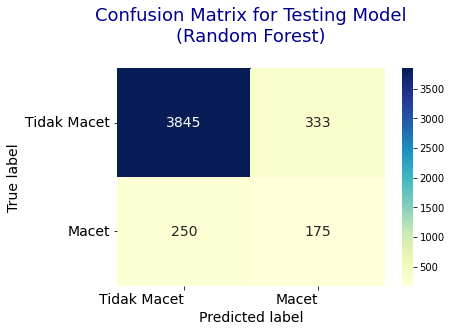

In [151]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('Tidak Macet', 'Macet'), ('Tidak Macet', 'Macet'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

Dari hasil dan analisa di atas, maka:

*   Jika kita menggunakan menggunakan algoritma Random Forest dengan memanggil RandomForestClassifier() dari sklearn tanpa menambahi parameter apapun, maka yang dihasilkan adalah model dengan seting default dari sklearn
*   Dari data training terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi dan recall sebesar 100%, dengan detil tebakan macet yang sebenarnya benar macet adalah 9821, tebakan tidak macet yang sebenarnya tidak macet adalah 9821, tebakan tidak macet yang sebenarnya benar macet adalah 0 dan tebakan macet yang sebenernya tidak macet adalah 0.
*   Dari data testing terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 87% dan recall sebesar 41%, dengan detil tebakan macet yang sebenarnya benar macet adalah 175, tebakan tidak macet yang sebenarnya tidak macet adalah 3845, tebakan tidak macet yang sebenarnya benar macet adalah 250 dan tebakan macet yang sebenernya tidak macet adalah 333.

##### Gradient Boosting Classifier

In [152]:
#Train the model
gbt_model = GradientBoostingClassifier().fit(X_train_SMOTE, y_train_SMOTE)
print(gbt_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Perfomansi Model Data Training - Menampilkan Metrics

In [153]:
# Predict
y_train_pred = gbt_model.predict(X_train_SMOTE)
# Print classification report 
print('Classification Report Training Model (Gradient Boosting):')
print(classification_report(y_train_SMOTE, y_train_pred))

Classification Report Training Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      9821
           1       0.87      0.87      0.87      9821

    accuracy                           0.87     19642
   macro avg       0.87      0.87      0.87     19642
weighted avg       0.87      0.87      0.87     19642



Perfomansi Model Data Training - Menampilkan Plots

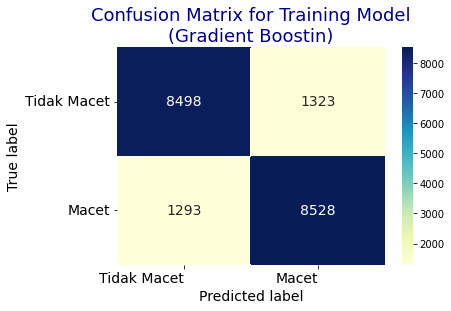

In [154]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train_SMOTE, y_train_pred)), ('Tidak Macet', 'Macet'), ('Tidak Macet', 'Macet'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Gradient Boostin)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

Performansi Model Data Testing - Menampilkan Metrics

In [155]:
# Predict
y_test_pred = gbt_model.predict(X_test)
# Print classification report 
print('Classification Report Testing Model (Gradient Boosting):')
print(classification_report(y_test, y_test_pred))

Classification Report Testing Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4178
           1       0.28      0.57      0.38       425

    accuracy                           0.82      4603
   macro avg       0.62      0.71      0.64      4603
weighted avg       0.89      0.82      0.85      4603



Performansi Model Data Testing - Menampilkan Plots

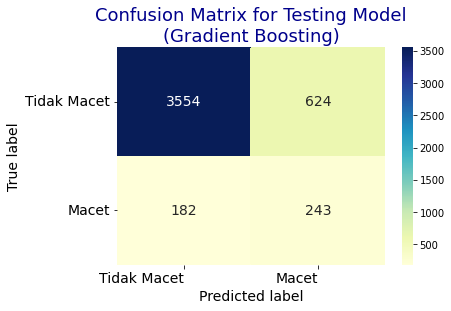

In [156]:
# Form confusion matrix as a DataFrame
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('Tidak Macet', 'Macet'), ('Tidak Macet', 'Macet'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

Dari hasil dan analisa di atas, maka:

*   Jika kita menggunakan menggunakan algoritma Gradient Boosting dengan memanggil GradientBoostingClassifier() dari sklearn tanpa menambahi parameter apapun, maka yang dihasilkan adalah model dengan seting default dari sklearn
*   Dari data training terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi dan recall sebesar 87%, dengan detil tebakan macet yang sebenarnya benar macet adalah 8528, tebakan tidak macet yang sebenarnya tidak macet adalah 8498, tebakan tidak macet yang sebenarnya benar macet adalah 1293 dan tebakan macet yang sebenernya tidak macet adalah 1323.
*   Dari data testing terlihat bahwasannya model mampu memprediksi data dengan menghasilkan akurasi sebesar 82% dan recall sebesar 57%, dengan detil tebakan macet yang sebenarnya benar macet adalah 243, tebakan tidak macet yang sebenarnya tidak macet adalah 3554, tebakan tidak macet yang sebenarnya benar macet adalah 182 dan tebakan macet yang sebenernya tidak macet adalah 624.

### LOAD AND PREDICT NEW DATA

In [172]:
# Load data
df = pd.read_csv(os.path.join(path, "npl_credit_scoring_test.csv"), encoding='utf-8')
df.head()

,X,jumlah_kartu,outstanding,limit_kredit,tagihan,total_pemakaian_tunai,total_pemakaian_retail,sisa_tagihan_tidak_terbayar,kode_cabang,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,rasio_pembayaran_6bulan,skor_delikuensi,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,sisa_tagihan_per_jumlah_kartu,sisa_tagihan_per_limit,total_pemakaian_per_limit,pemakaian_3bln_per_limit,pemakaian_6bln_per_limit,utilisasi_3bulan,utilisasi_6bulan
0,6188,2,5025000,5000000.0,833333.0,900000.0,538002.0,3290742.0,F,100.0,0.00,100.0,150.0,0,6.75,1438002.0,1645371.0,0.658,0.288,0.0322,6.600000e-08,1.0200,1.2000
1,4783,2,509019,3000000.0,258000.0,0.0,418000.0,0.0,A,0.0,0.00,24.5,0.0,0,5.42,418000.0,0.0,0.000,0.139,0.0695,0.000000e+00,0.0897,0.0592
2,13414,2,5153766,5000000.0,5007495.0,0.0,5019950.0,5515204.0,F,0.0,9.88,75.2,10.0,0,7.67,5019950.0,2757602.0,1.100,1.000,0.4390,3.550000e-01,0.6740,0.3630
3,11819,3,29214412,35000000.0,28509908.0,0.0,4148000.0,29214022.0,A,0.0,0.00,15.0,30.2,0,13.70,4148000.0,9738007.0,0.835,0.119,0.0833,3.620000e-02,0.7920,0.7430
4,7416,2,40929,3000000.0,40100.0,0.0,0.0,0.0,B,0.0,0.00,0.0,0.0,0,6.42,0.0,0.0,0.000,0.000,0.0000,0.000000e+00,0.0107,0.0000


In [175]:
# Membagi train test data
drop = ['X','outstanding','kode_cabang','limit_kredit', 'tagihan', 'total_pemakaian_retail', 'sisa_tagihan_per_jumlah_kartu', 'sisa_tagihan_per_limit', 'utilisasi_6bulan', 'rasio_pembayaran_6bulan', 'pemakaian_6bln_per_limit']
X = df.drop(drop, axis=1)

print("X Test : ", len(X))

X Test :  150


In [179]:
X.head()

,jumlah_kartu,total_pemakaian_tunai,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,skor_delikuensi,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,total_pemakaian_per_limit,pemakaian_3bln_per_limit,utilisasi_3bulan,prediction
0,2,900000.0,3290742.0,100.0,0.00,100.0,0,6.75,1438002.0,0.288,0.0322,1.0200,0
1,2,0.0,0.0,0.0,0.00,24.5,0,5.42,418000.0,0.139,0.0695,0.0897,0
2,2,0.0,5515204.0,0.0,9.88,75.2,0,7.67,5019950.0,1.000,0.4390,0.6740,0
3,3,0.0,29214022.0,0.0,0.00,15.0,0,13.70,4148000.0,0.119,0.0833,0.7920,0
4,2,0.0,0.0,0.0,0.00,0.0,0,6.42,0.0,0.000,0.0000,0.0107,1


In [178]:
y_pred = rdf_model.predict(X)
X['prediction'] = y_test_pred
X.head()

,jumlah_kartu,total_pemakaian_tunai,sisa_tagihan_tidak_terbayar,rasio_pembayaran,persentasi_overlimit,rasio_pembayaran_3bulan,skor_delikuensi,jumlah_tahun_sejak_pembukaan_kredit,total_pemakaian,total_pemakaian_per_limit,pemakaian_3bln_per_limit,utilisasi_3bulan,prediction
0,2,900000.0,3290742.0,100.0,0.00,100.0,0,6.75,1438002.0,0.288,0.0322,1.0200,0
1,2,0.0,0.0,0.0,0.00,24.5,0,5.42,418000.0,0.139,0.0695,0.0897,0
2,2,0.0,5515204.0,0.0,9.88,75.2,0,7.67,5019950.0,1.000,0.4390,0.6740,0
3,3,0.0,29214022.0,0.0,0.00,15.0,0,13.70,4148000.0,0.119,0.0833,0.7920,0
4,2,0.0,0.0,0.0,0.00,0.0,0,6.42,0.0,0.000,0.0000,0.0107,1


### KESIMPULAN/SARAN

Model yang baik adalah model yang mampu memberikan performa bagus di fase training dan testing model.

* Over-Fitting adalah suatu kondisi dimana model mampu memprediksi dengan sangat baik di fase training, akan tetapi tidak mampu memprediksi sama baiknya di fase testing.
* Under-Fitting adalah suatu kondisi dimana model kurang mampu memprediksi dengan baik di fase training, akan tetapi mampu memprediksi dengan baik di fase testing.
* Appropriate-Fitting adalah suatu kondisi dimana model mampu memprediksi dengan baik di fase training maupun di fase testing.

Berdasarkan pemodelan yang telah dilakukan dengan menggunakan Logistic Regression, Random Forest dan Extreme Gradiant Boost, maka dapat disimpulkan untuk memprediksi kredit macet dari nasabah dengan menggunakan dataset ini model terbaiknya adalah menggunakan algortima Extreme Gradiant Boost. Hal ini dikarenakan performa dari model Extreme Gradiant Boost cenderung mampu memprediksi sama baiknya di fase training maupun testing (akurasi training 87%, akurasi testing 82%), di lain sisi algoritma Logistic Regression kurang baik memprediksi di fase testing dan training serta algoritma Random Forest cenderung Under-Fitting. Akan tetapi hal ini tidak menjadikan kita untuk menarik kesimpulan bahwsannya jika untuk melakukan pemodelan apapun maka digunakan Extreme Gradiant Boost, kita tetap harus melakukan banyak percobaan model untuk menentukan mana yang terbaik.